# Calculate the storage size of Satellite Images on Greek Region

The goal of this Notebook is to calculate the storage size of Sentintinel-2 products for the Greek region only.
1. First, we load a dataset, as geopandas dataframe, that corresponds to the Georeference System of Sentinel-2 mission.
2. Second, we load the Greek Region as geopandas dataframe. We will use Periferies as subregions of Greece.
3. Then we get the intersection between the two geodataframes.
4. We will check the size of Sentinel-2 products for 1 year.


Useful links:
* Sentinel-2 product naming: https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/naming-convention
* MGRS Map: https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/naming-convention
* Greek Regions: https://geodata.gov.gr/dataset/periphereies-elladas
* Shapefile with MGRS tilling: https://github.com/justinelliotmeyers/Sentinel-2-Shapefile-Index
* Cloud Optimized Geotiffs Sentinel-2: https://registry.opendata.aws/sentinel-2-l2a-cogs/
   



### We load the neccessary libaries

In [83]:
import folium # library for interactive maps
import geopandas as gpd # libarry to load shapefiles and handle geodata
import boto3 # library to connect to S3 bucket 
from botocore import UNSIGNED
from botocore.config import Config
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

### Load the Sentinel-2 Index Tiles
The Sentinel-2 tiles uses the MGRS System. You can download the shapefile from the link below.
https://github.com/justinelliotmeyers/Sentinel-2-Shapefile-Index 

In [58]:
# Load shapefile with MGRS Tiles
shapefile = gpd.read_file(r"C:\Users\a.gkikas\Desktop\New folder\Sentinel-2-Shapefile-Index-master\sentinel_2_index_shapefile.shp")
print(len(shapefile))
print(shapefile)


56984
        Name                                           geometry
0      01CCV  POLYGON Z ((180.00000 -73.05974 0.00000, 176.8...
1      01CCV  POLYGON Z ((-180.00000 -72.07333 0.00000, -179...
2      01CDH  POLYGON Z ((180.00000 -83.80855 0.00000, 174.7...
3      01CDH  POLYGON Z ((-180.00000 -82.82590 0.00000, -176...
4      01CDJ  POLYGON Z ((180.00000 -82.91344 0.00000, 175.7...
...      ...                                                ...
56979  60XWP  POLYGON Z ((-180.00000 80.13994 0.00000, -177....
56980  60XWQ  POLYGON Z ((180.00000 80.05179 0.00000, 176.99...
56981  60XWQ  POLYGON Z ((-180.00000 81.03542 0.00000, -176....
56982  60XWR  POLYGON Z ((180.00000 80.94781 0.00000, 176.99...
56983  60XWR  POLYGON Z ((-180.00000 81.93139 0.00000, -176....

[56984 rows x 2 columns]


### Filter Tiles based on the Area of Interest
Greek region intersects with the Tiles (34T, 34S, 35T, 35S). So we can filter based on that to keep only the necessary records

In [59]:
# Greek region intersects with the Tiles (34T, 34S, 35T, 35S), so we do a filtering first
# 34T, 34S, 35T, 35S
mgrs_tiles = shapefile[shapefile['Name'].str.contains('3[45][TS]', regex= True, na=False)]
print(len(mgrs_tiles))

204


As you see, we managed to keep only 204 from the 56984 rows.
Now lets, plot to check the tiles

In [172]:
# plot the tiles. Note  that these tiles are childs the previous zoom.
# We need to make another filtering based on the greek regions(periferies)
m = folium.Map(zoom_start=10, tiles="cartodbpositron")

folium.GeoJson(mgrs_tiles).add_to(m)
m

### Load Greek Region
Now, we need to load teh Greek Region. This can be done by geting the Periferies of Greece, which can be found on the link below.
https://geodata.gov.gr/dataset/periphereies-elladas

<Axes: >

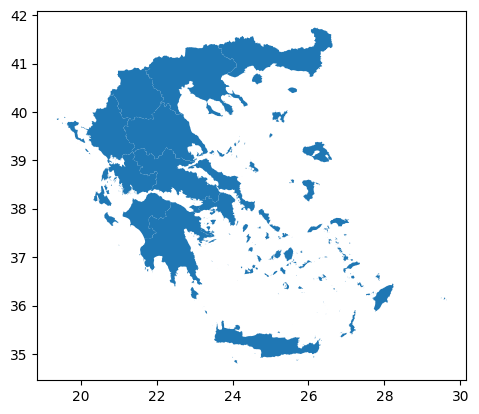

In [61]:
# Load the Greek regions
greek_region = gpd.read_file(r"C:\Users\a.gkikas\Desktop\New folder\Greek_Regions\d7f50467-e5ef-49ac-a7ce-15df3e2ed738.shp",encoding='utf-8')

greek_region.plot()

#### Now check if the two geopanda dataframes are in the same Georeferece System.

In [62]:
#check if the two geopdataframes are on the same Georeference system
print(shapefile.crs)
print("--------------")
print(greek_region.crs)


GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
--------------
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH],AUTHORITY["EPSG","4326"]]


### Get the Intersection between the two GeoPandas Dataframes.

In [63]:
# Get the intersected regions with the tiles 
join = gpd.sjoin(left_df=shapefile, right_df=greek_region,  how="inner", predicate="intersects")
print(f"Number of tiles {len(join)}")

Number of tiles 108


### Plot the intersected tiles
As you show we namange to keep only the neccessary tiles, which are 108. 

In [140]:
m = folium.Map(zoom_start=10, tiles="cartodbpositron")
folium.GeoJson(join).add_to(m)
m

### Calculate the storage size 

In [92]:
# help function to calculate the size of each folder inside the bucket
from botocore.handlers import disable_signing
def get_size(bucket, path):
    s3 = boto3.resource('s3')
    s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
    my_bucket = s3.Bucket(bucket)
    total_size = 0

    for obj in my_bucket.objects.filter(Prefix=path):
        total_size = total_size + obj.size
    return total_size

In [107]:
join["2023"] = join['Name'].apply(lambda row: get_size("e84-earth-search-sentinel-data",f"sentinel-2-c1-l2a/{row[0:2]}/{row[2]}/{row[3:]}/2023/"))

In [135]:
# join[["Name","2023"]]
print("Size of satellite products of the year 2023: ", join["2023"].sum()/1024/1024/1024/1024, "Terrabytes")

Size of satellite products of year 2023:  13.317454281003847 Terrabytes


## Conclusion 
As we saw, Greece requires 13 Terabytes of storage, for a full year. 
Keep in mind that :
* We calculate the size of all products. We can filter based on cloud cover, where we can exclude the products that have more than ~70% cloud cover.
* We exclude overlap tiles entirely(or almost entirely) with others.
* Furthermore, exclude tiles that cover a tiny portion of Greek regions, which is also covered by another tile. For example, check the tiles, near the Greek-Albanian Borders.

### Free Open Data:
* Use Open data from the Internet and save storage space. Currently, there are three options:
    *  Google Sentinel-2 gcloud storage:
        *  Uses the SAFE Format(similar to the Copernicus spacehub).
        *  Download products for free
        *  The records are from 2018, I believe.
        *  Read the products from google storage.   
        *  Not recommended because, they are in JP2K format, which is not cloud-optimized format.
    *  Microsoft Planetary:
        *  Use STAC-API format for the products(The new format for Spatial Temporal datasets).
        *  Download for free.
        *  Products from 2018.
        *  Search/read/download the products on the fly.
        *  Saved in Cloud Optimized Geotiffs format.Suitable for Map Tiles/Layers.
    *  Element 84 AWS Open Data:
        *  Use STAC-API format for the products(The new format for Spatial Temporal datasets).
        *  Download for free.
        *  Products from 2018.
        *  Search/read/download the products on the fly.
        *  Saved in Cloud Optimized Geotiffs format(also can provide JP2K format).Suitable for Map Tiles/Layers.